# Breast Cancer Classification

In [1]:
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
from torch.utils import data

In [191]:
from sklearn.model_selection import train_test_split

In [77]:
from os import path
import pandas as pd
from collections import defaultdict
from skimage import io, transform

In [144]:
from PIL import Image
import os.path

In [3]:
import tensorflow as tf
from PIL import Image
import numpy as np
import cv2
import glob

/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [37]:
rootdir = '/Users/yingyinxiao/breast_cancer'
path_malignant = '/data/malignant'
path_benign = '/data/benign'

### Create the CSV file
- png name with directory
- pixel numbers
- categories
- 1/0

In [82]:
os.listdir()

['untitled folder',
 '.DS_Store',
 'csv.csv',
 'Yingyin.ipynb',
 'README.md',
 '.ipynb_checkpoints',
 '.git']

In [120]:
dic4csv = defaultdict(list)

In [121]:
index = 0
for root, dirs, files in os.walk(rootdir):
    for file in files:
        if file.endswith(".png"):
            full_path = ''
            values = root.split('/')
            ordered = [x for x in values if x]
            ordered.append(file)
            
            for i in ordered:
                full_path+='/'+i

            dic4csv[index] = [values[-2], values[-3], values[-4], values[-1], index, full_path]
            index +=1

In [123]:
csv = pd.DataFrame(data = dic4csv).transpose().rename(columns = {0: 'img_name', 1: 'category', 2: 'binary',\
                                                                 3: 'img_size', 4: 'label', 5: 'full_path'})
csv.head()

,img_name,category,binary,img_size,label,full_path
0,SOB_M_MC_14-13418DE,mucinous_carcinoma,malignant,100X,0,/Users/yingyinxiao/breast_cancer/data/malignan...
1,SOB_M_MC_14-13418DE,mucinous_carcinoma,malignant,400X,1,/Users/yingyinxiao/breast_cancer/data/malignan...
2,SOB_M_MC_14-13418DE,mucinous_carcinoma,malignant,400X,2,/Users/yingyinxiao/breast_cancer/data/malignan...
3,SOB_M_MC_14-13418DE,mucinous_carcinoma,malignant,400X,3,/Users/yingyinxiao/breast_cancer/data/malignan...
4,SOB_M_MC_14-13418DE,mucinous_carcinoma,malignant,400X,4,/Users/yingyinxiao/breast_cancer/data/malignan...


In [122]:
pd.DataFrame(data = dic4csv).transpose()[5][0]

'/Users/yingyinxiao/breast_cancer/data/malignant/mucinous_carcinoma/SOB_M_MC_14-13418DE/100X/SOB_M_MC-14-13418DE-100-002.png'

In [124]:
csv['img_name'] = csv['img_name'] +'_'+ csv['img_size']
csv['img_name']

0       SOB_M_MC_14-13418DE_100X
1       SOB_M_MC_14-13418DE_400X
2       SOB_M_MC_14-13418DE_400X
3       SOB_M_MC_14-13418DE_400X
4       SOB_M_MC_14-13418DE_400X
                  ...           
3878    SOB_B_PT_14-29315EF_200X
3879    SOB_B_PT_14-29315EF_200X
3880    SOB_B_PT_14-29315EF_200X
3881    SOB_B_PT_14-29315EF_200X
3882    SOB_B_PT_14-29315EF_200X
Name: img_name, Length: 3883, dtype: object

In [125]:
def helper(row):
    if row == 'malignant':
        return 1
    else: return 0

In [126]:
csv['binary'] = csv['binary'].apply(helper)

In [127]:
csv.binary.value_counts()

0    2490
1    1393
Name: binary, dtype: int64

In [128]:
csv.to_csv('csv.csv')

In [129]:
index == csv.shape[0]

True

### Early exploration

In [101]:
csv.describe()

,binary
count,3883.000000
mean,0.358743
std,0.479693
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [48]:
csv.groupby(['binary', 'img_size']).count()

img_name  category  label  full_path
binary    img_size                                      
benign    100X           648       648    648        648
          200X           623       623    623        623
          400X           594       594    594        594
          40X            625       625    625        625
malignant 100X           395       395    395        395
          200X           367       367    367        367
          400X           288       288    288        288
          40X            343       343    343        343

Text(0.5, 1.0, 'Bar Chart of Benign and Malignant Cases')

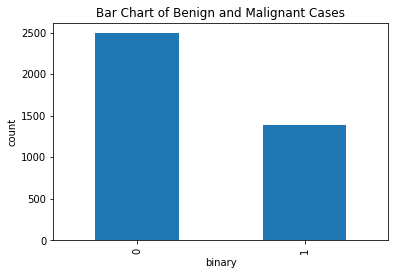

In [102]:
fig, ax = plt.subplots()    
csv.groupby('binary')['img_name'].count().plot.bar()
plt.ylabel('count')
plt.title('Bar Chart of Benign and Malignant Cases')

The binary data is obviously imbalanced, which will be adjusted later. There are more benigh than malignant images.

In [161]:
b1 = list(csv[csv.binary == 1].img_size.value_counts())
b0 = list(csv[csv.binary == 0].img_size.value_counts())
b1, b0

([395, 367, 343, 288], [648, 625, 623, 594])

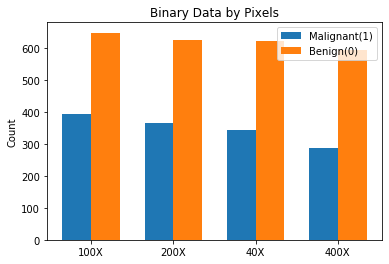

In [169]:
N = 4

ind = np.arange(N) 
width = 0.35       
plt.bar(ind, b1, width, label='Malignant(1)')
plt.bar(ind + width, b0, width,
    label='Benign(0)')

plt.ylabel('Count')
plt.title('Binary Data by Pixels')

plt.xticks(ind + width / 2, ('100X', '200X', '40X', '400X'))
plt.legend(loc='upper right')
plt.show()

In [211]:
b1_ = (csv[csv.binary == 1].category.value_counts())
category1 = list(csv[csv.binary == 1].category.value_counts().index)
b0_ = (csv[csv.binary == 0].category.value_counts())
category0 = list(csv[csv.binary == 0].category.value_counts().index)

([<matplotlib.axis.XTick at 0x1a4bf84e90>,
 <a list of 4 Text xticklabel objects>)

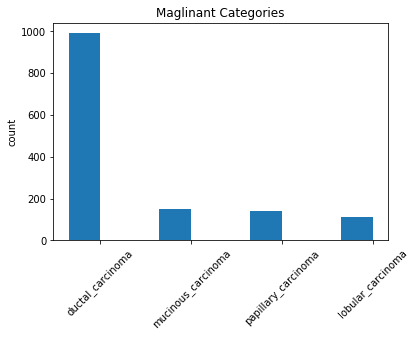

In [219]:
plt.bar(ind, b1_, width)
plt.ylabel('count')
plt.title('Maglinant Categories')
plt.xticks(ind + width / 2, category1, rotation = 45)

([<matplotlib.axis.XTick at 0x647705d10>,
 <a list of 4 Text xticklabel objects>)

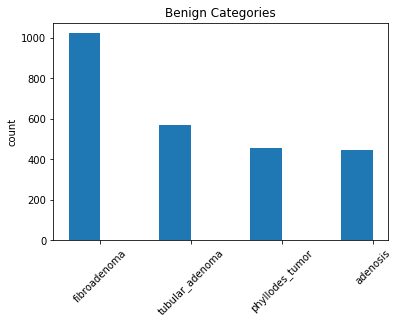

In [220]:
plt.bar(ind, b0_, width)
plt.ylabel('count')
plt.title('Benign Categories')
plt.xticks(ind + width / 2, category0, rotation = 45)

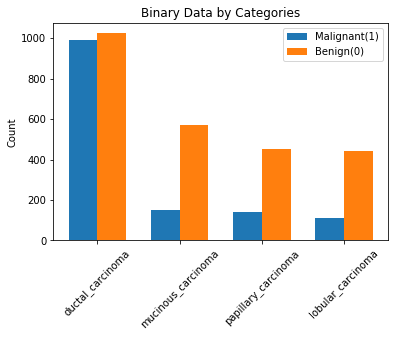

In [190]:
N = 4

ind = np.arange(N) 
width = 0.35       
plt.bar(ind, b1_, width, label='Malignant(1)')
plt.bar(ind + width, b0_, width,
    label='Benign(0)')

plt.ylabel('Count')
plt.title('Binary Data by Categories')

plt.xticks(ind + width / 2, category, rotation = 45)
plt.legend(loc='upper right')
plt.show()

### Data loader

In [180]:
csv.head()

,img_name,category,binary,img_size,label,full_path
0,SOB_M_MC_14-13418DE_100X,mucinous_carcinoma,1,100X,0,/Users/yingyinxiao/breast_cancer/data/malignan...
1,SOB_M_MC_14-13418DE_400X,mucinous_carcinoma,1,400X,1,/Users/yingyinxiao/breast_cancer/data/malignan...
2,SOB_M_MC_14-13418DE_400X,mucinous_carcinoma,1,400X,2,/Users/yingyinxiao/breast_cancer/data/malignan...
3,SOB_M_MC_14-13418DE_400X,mucinous_carcinoma,1,400X,3,/Users/yingyinxiao/breast_cancer/data/malignan...
4,SOB_M_MC_14-13418DE_400X,mucinous_carcinoma,1,400X,4,/Users/yingyinxiao/breast_cancer/data/malignan...


In [192]:
csv.groupby(['binary', 'category']).describe()

img_name                                        \
                              count unique                       top freq   
binary category                                                             
0      adenosis                 444     16   SOB_B_A_14-22549CD_100X   36   
       fibroadenoma            1024     40     SOB_B_F_14-14134_200X   38   
       phyllodes_tumor          453     12  SOB_B_PT_14-21998AB_100X   66   
       tubular_adenoma          569     28     SOB_B_TA_14-16184_40X   39   
1      ductal_carcinoma         991    140     SOB_M_DC_14-17614_40X   39   
       lobular_carcinoma        112     19    SOB_M_LC_14-12204_400X   24   
       mucinous_carcinoma       150     32     SOB_M_MC_14-19979_40X   26   
       papillary_carcinoma      140     23    SOB_M_PC_14-19440_200X   33   

                           img_size                   label                    \
                              count unique   top freq count unique   top freq   
binary category                                                                 
0      adenosis                 444      4   40X  114   444    444  1836    1   
       fibroadenoma            1024      4  200X  264  1024   1024  3429    1   
       phyllodes_tumor          453      4  100X  121   453    453  3882    1   
       tubular_adenoma          569      4  100X  150   569    569  2047    1   
1      ductal_carcinoma         991      4  100X  288   991    991  1280    1   
       lobular_carcinoma        112      4  400X   43   112    112  1392    1   
       mucinous_carcinoma       150      4   40X   55   150    150   149    1   
       papillary_carcinoma      140      4  200X   53   140    140   255    1   

                           full_path         \
                               count unique   
binary category                               
0      adenosis                  444    444   
       fibroadenoma             1024   1024   
       phyllodes_tumor           453    453   
       tubular_adenoma           569    569   
1      ductal_carcinoma          991    991   
       lobular_carcinoma         112    112   
       mucinous_carcinoma        150    150   
       papillary_carcinoma       140    140   

                                                                               \
                                                                          top   
binary category                                                                 
0      adenosis             /Users/yingyinxiao/breast_cancer/data/benign/a...   
       fibroadenoma         /Users/yingyinxiao/breast_cancer/data/benign/f...   
       phyllodes_tumor      /Users/yingyinxiao/breast_cancer/data/benign/p...   
       tubular_adenoma      /Users/yingyinxiao/breast_cancer/data/benign/t...   
1      ductal_carcinoma     /Users/yingyinxiao/breast_cancer/data/malignan...   
       lobular_carcinoma    /Users/yingyinxiao/breast_cancer/data/malignan...   
       mucinous_carcinoma   /Users/yingyinxiao/breast_cancer/data/malignan...   
       papillary_carcinoma  /Users/yingyinxiao/breast_cancer/data/malignan...   

                                 
                           freq  
binary category                  
0      adenosis               1  
       fibroadenoma           1  
       phyllodes_tumor        1  
       tubular_adenoma        1  
1      ductal_carcinoma       1  
       lobular_carcinoma      1  
       mucinous_carcinoma     1  
       papillary_carcinoma    1

In [177]:
csv.shape

(3883, 6)

In [103]:
labels = dict(zip(csv['img_name'], csv['label']))

In [33]:
csv_path = 'Users⁩/⁨yingyinxiao⁩/⁨breast_cancer⁩/⁨Breast-Cancer-Classification⁩/csv.csv'
root_dir = "Users/⁨yingyinxiao⁩/⁨breast_cancer⁩/data⁨"

In [133]:
class DataLoader(data.Dataset):
    """
    Args:
        csv_file (string): Path to the csv file with annotations.
        root_dir (string): Directory with all the images.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    def __init__(self, csv_file, transform = None):
        'Initialization'
        self.frame = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.frame)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        img_name = self.frame.iloc[index, 6]
        image = io.imread(img_name)
        
        label = self.frame.iloc[index, 3]
        # Load data and get label
         
        sample = {'image': image, 'label': label}
        
        if self.transform:
            sample = self.transform(sample)

        return sample

In [ ]:
def get_loader(dataset, param):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
    
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)
        

### Iterate through some images

In [178]:
dataset = Dataset('csv.csv')

0 (460, 700, 3) 1
1 (460, 700, 3) 1
2 (460, 700, 3) 1
3 (460, 700, 3) 1


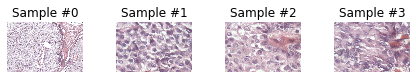

In [186]:
fig = plt.figure()

for i in range(len(dataset)):
    sample = dataset[i]

    print(i, sample['image'].shape, sample['label'])

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    plt.imshow(sample['image'])

    if i == 3:
        plt.show()
        break

### See if the images are in the same size

In [ ]:
filename = os.path.join()
img = Image.open(filename)
print(img.size)